In [11]:
import os
import json
import random
import wandb
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet18
from PIL import Image
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
import nltk
import pandas as pd
import random
from tqdm import tqdm
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Oscar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:

# Config
wandb.init(project="Group19_Lab3_flickr30k-captioning")
config = wandb.config
config.batch_size = 128
config.embed_size = 256
config.hidden_size = 512
config.num_layers = 2
config.learning_rate = 1e-3
config.num_epochs = 20
config.max_len = 81
#pretrained_embeddings = 'glove.6B.300d.txt'  # Path to GloVe embeddings


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_bleu,▁▃▃▅▄▅▆▅▇▇▇█▇▇█████▇▇
epoch,0
train_loss,2.50731
val_bleu,0.09151


In [13]:

# --- Dataset and Preprocessing ---
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #index to string
        self.stoi = {v: k for k, v in self.itos.items()}             #string to index

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            tokens = word_tokenize(sentence.lower())
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        return [self.stoi.get(word, self.stoi["<UNK>"]) for word in word_tokenize(text.lower())]
    
"""class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform, vocab, max_len=config.max_len):
        self.max_len = max_len
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        # Load CSV and group comments by image
        df = pd.read_csv(captions_file, delimiter='|', encoding='utf-8', quotechar='"', escapechar='\\')
        df.dropna(inplace=True)
        df.columns.str.strip()

        # Create a list of (image_name, caption) pairs
        self.image_caption_pairs = []
        for image_name, captions in df.groupby("image_name")[' comment']:
            for caption in captions:
                self.image_caption_pairs.append((image_name, caption))
        # Build vocab using all captions
        all_captions = [caption for _, caption in self.image_caption_pairs]
        self.vocab.build_vocabulary(all_captions)
        

    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_name, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.root_dir, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            raise

        if self.transform:
            image = self.transform(image)

        # Convert caption to tensor of word indices
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        # Pad the caption to max_len
        if len(numericalized_caption) < self.max_len:
            numericalized_caption += [self.vocab.stoi["<PAD>"]] * (self.max_len - len(numericalized_caption))
        else:
            numericalized_caption = numericalized_caption[:self.max_len]

        return image, torch.tensor(numericalized_caption)
    """
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform, vocab, max_len=30):
        self.max_len = max_len
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        # Load CSV and group comments by image
        df = pd.read_csv(captions_file, delimiter='|', encoding='utf-8', quotechar='"', escapechar='\\')
        df.dropna(inplace=True)
        df.columns.str.strip() 
        print(df.columns.tolist())
        # Group all captions per image
        self.captions_dict = df.groupby("image_name")[' comment'].apply(list).to_dict()
        self.image_names = list(self.captions_dict.keys())

        # Build vocab using all captions
        all_captions = [caption for captions in self.captions_dict.values() for caption in captions]
        self.vocab.build_vocabulary(all_captions)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.root_dir, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            print(f"Error loading image: {image_path}, {e}")
            raise

        if self.transform:
            image = self.transform(image)

        # Sample a random caption for this image
        captions = self.captions_dict[image_name]
        caption = random.choice(captions)

        # Convert caption to tensor of word indices
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        # Pad the caption to max_len

        if len(numericalized_caption) < self.max_len:
            numericalized_caption += [self.vocab.stoi["<PAD>"]] * (self.max_len - len(numericalized_caption))
        else:
            numericalized_caption = numericalized_caption[:self.max_len]
        
        

        return image, torch.tensor(numericalized_caption)

def collate_fn(batch, pad_idx):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=pad_idx)
    return torch.stack(images), captions


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_dir = r"C:\Skola\D7047e\Lab3\flickr30k_images\flickr30k_images\flickr30k_images"
cap_dir = r"c:\Skola\D7047e\Lab3\flickr30k_images\flickr30k_images\results_clean.csv"


vocab = Vocabulary(freq_threshold=5)
dataset = FlickrDataset(root_dir=img_dir, captions_file=cap_dir, transform=transform, vocab=vocab, max_len=config.max_len)

for i in range(5):
    img, cap = dataset[i]
    print(img.shape, cap)

train_data, val_data, test_data = random_split(dataset, [.8, .1, .1])

train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab.stoi["<PAD>"]))
val_loader = DataLoader(val_data, batch_size=config.batch_size, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab.stoi["<PAD>"]))
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab.stoi["<PAD>"]))


['image_name', ' comment_number', ' comment']
torch.Size([3, 224, 224]) tensor([ 1,  4, 37, 38, 39,  3, 40, 20,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0])
torch.Size([3, 224, 224]) tensor([ 1, 64, 28, 53, 32, 65, 66, 20,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0])
torch.Size([3, 224, 224]) tensor([ 1, 32, 77, 78, 71, 18, 73, 83, 84, 85, 20,  2,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [14]:


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]  # Remove avgpool and fc
        self.resnet = nn.Sequential(*modules)
        self.conv = nn.Conv2d(512, embed_size, kernel_size=1)  # Project to embed_size

    def forward(self, images):
        features = self.resnet(images)  # (B, 512, 7, 7)
        features = self.conv(features)  # (B, embed_size, 7, 7)
        features = features.flatten(2).permute(0, 2, 1)  # (B, 49, embed_size)
        return features  # Each image is now a sequence of 49 vectors

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (B, num_pixels, encoder_dim)
        # decoder_hidden: (B, decoder_dim)
        att1 = self.encoder_att(encoder_out)  # (B, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (B, 1, attention_dim)
        att = torch.tanh(att1 + att2)  # (B, num_pixels, attention_dim)
        e = self.full_att(att).squeeze(2)  # (B, num_pixels)
        alpha = F.softmax(e, dim=1)  # (B, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (B, encoder_dim)
        return context, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, attention_dim=256):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(embed_size, hidden_size, attention_dim)
        self.lstm = nn.LSTMCell(embed_size + embed_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        embeddings = self.embed(captions[:, :-1])  # (B, max_len-1, embed_size)
        h, c = self.init_hidden_state(encoder_out)
        outputs = []
        for t in range(embeddings.size(1)):
            context, alpha = self.attention(encoder_out, h)
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.linear(h)
            outputs.append(output.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)  # (B, max_len-1, vocab_size)
        return outputs

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [15]:


"""# --- Encoder and Decoder ---
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        #self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-2])   # Exclude <EOS> and <PAD> tokens
        features = features.unsqueeze(1)
        inputs = torch.cat((features, embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs"""


'# --- Encoder and Decoder ---\nclass EncoderCNN(nn.Module):\n    def __init__(self, embed_size):\n        super(EncoderCNN, self).__init__()\n        self.resnet = resnet18(pretrained=True)\n        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)\n\n    def forward(self, images):\n        features = self.resnet(images)\n        return features\n\nclass DecoderRNN(nn.Module):\n    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):\n        super(DecoderRNN, self).__init__()\n        #self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)\n        self.embed = nn.Embedding(vocab_size, embed_size)\n        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)\n        self.linear = nn.Linear(hidden_size, vocab_size)\n\n    def forward(self, features, captions):\n        embeddings = self.embed(captions[:, :-2])   # Exclude <EOS> and <PAD> tokens\n        features = features.unsqueeze(1)\n        inputs = to

In [16]:

# --- Training ---
encoder = EncoderCNN(config.embed_size).to(device)
decoder = DecoderRNN(config.embed_size, config.hidden_size, len(vocab.stoi), config.num_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
params = list(decoder.parameters()) + list(encoder.parameters())

optimizer = torch.optim.AdamW(params, lr=config.learning_rate, weight_decay=1e-2)


def train():
    encoder.train()
    decoder.train()
    best_bleu = 0
    best_encoder_state = None
    best_decoder_state = None

    for epoch in range(config.num_epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch}")
        for imgs, caps in loop:
            imgs, caps = imgs.to(device), caps.to(device)
            features = encoder(imgs)
            outputs = decoder(features, caps)
            loss = criterion(outputs.reshape(-1, outputs.size(2)), caps[:, 1:].reshape(-1))  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        wandb.log({"epoch": epoch, "train_loss": total_loss / len(train_loader)})
        print(f"\nEpoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")
        val_bleu = evaluate(val_loader, encoder, decoder, epoch)

        # Save best model
        if val_bleu > best_bleu:
            best_bleu = val_bleu
            best_encoder_state = encoder.state_dict()
            best_decoder_state = decoder.state_dict()
            print(f"New best BLEU: {best_bleu:.4f} at epoch {epoch}")

    # Load best model weights before returning
    encoder.load_state_dict(best_encoder_state)
    decoder.load_state_dict(best_decoder_state)
    return encoder, decoder, best_bleu

def evaluate(loader, encoder, decoder, epoch):
    encoder.eval()
    decoder.eval()
    total_bleu = 0
    loop = tqdm(loader, desc="Evaluating")
    one_generation = True
    with torch.no_grad():
        for imgs, caps in loop:
            imgs = imgs.to(device)
            features = encoder(imgs)
            batch_bleu = 0
            for i in range(features.size(0)):
                output_ids = generate_caption(decoder, features[i].unsqueeze(0), vocab)
                reference = [vocab.itos[idx.item()] for idx in caps[i] if idx.item() not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"]]]
                candidate = [vocab.itos[idx] for idx in output_ids if idx not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]
                if one_generation:
                    one_generation = False
                    print(f"Generated caption: {candidate}")
                    print(f"Reference caption: {reference}")
                bleu = sentence_bleu([reference], candidate, weights=(0.5, 0.5))
                batch_bleu += bleu
            total_bleu += batch_bleu / features.size(0)
            loop.set_postfix(bleu=batch_bleu / features.size(0))
    avg_bleu = total_bleu / len(loader)
    wandb.log({"val_bleu": avg_bleu})
    print(f"\nValidation BLEU score: {avg_bleu:.4f}")
    encoder.train()
    decoder.train()
    return avg_bleu

def generate_caption(decoder, feature, vocab, max_len=20, beam_width=3):
    device = feature.device
    sos_idx = vocab.stoi["<SOS>"]
    eos_idx = vocab.stoi["<EOS>"]

    # Initialize hidden and cell state
    h, c = decoder.init_hidden_state(feature)
    initial_states = (h, c)

    # Each element in the beam is (sequence, hidden_state, score)
    sequences = [([sos_idx], initial_states, 0.0)]

    with torch.no_grad():
        for step in range(max_len):
            all_candidates = []
            for seq, states, score in sequences:
                if seq[-1] == eos_idx:
                    all_candidates.append((seq, states, score))
                    continue

                input_token = torch.tensor([seq[-1]], device=device)
                if len(seq) == 1:
                    context = feature.mean(dim=1)  # (1, embed_size)
                    input_emb = decoder.embed(input_token)  # (1, embed_size)
                    lstm_input = torch.cat([input_emb, context], dim=1)  # (1, embed_size*2)
                else:
                    input_emb = decoder.embed(input_token)  # (1, embed_size)
                    context, _ = decoder.attention(feature, states[0])  # states[0] is h
                    lstm_input = torch.cat([input_emb, context], dim=1)  # (1, embed_size*2)

                h, c = decoder.lstm(lstm_input, states)  # states is (h, c)
                new_states = (h, c)
                output = decoder.linear(h)  # (1, vocab_size)
                log_probs = torch.log_softmax(output, dim=1)  # (1, vocab_size)

                top_log_probs, top_indices = log_probs.topk(beam_width)
                for i in range(beam_width):
                    next_token = top_indices[0, i].item()
                    next_score = score + top_log_probs[0, i].item()
                    all_candidates.append((seq + [next_token], new_states, next_score))

            sequences = sorted(all_candidates, key=lambda tup: tup[2], reverse=True)[:beam_width]
            if all(seq[-1] == eos_idx for seq, _, _ in sequences):
                break

    # Return the sequence with the highest score (excluding <SOS> and after <EOS>)
    best_seq = sequences[0][0]
    if eos_idx in best_seq:
        end_idx = best_seq.index(eos_idx)
        best_seq = best_seq[1:end_idx]
    else:
        best_seq = best_seq[1:]
    return best_seq





C:\Users\Oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Train loader batches: {len(train_loader)}")
print(f"vocab size: {len(vocab.stoi)}")
print(f"sample vocab: {list(vocab.stoi.items())[100:130]}")



Train dataset size: 25427
Train loader batches: 199
vocab size: 7736
sample vocab: [('gray', 100), ('black', 101), ('stove', 102), ('guy', 103), ('cooking', 104), ('joking', 105), ('around', 106), ('camera', 107), ('kitchen', 108), ('food', 109), ('preparing', 110), ('meal', 111), ('people', 112), ('photo', 113), ('playing', 114), ('guitar', 115), ('other', 116), ('poking', 117), ('him', 118), ('holds', 119), ('observes', 120), ('his', 121), ('fixing', 122), ('players', 123), ('costume', 124), ('another', 125), ("'s", 126), ('coat', 127), ('boys', 128), ('sits', 129)]


In [18]:

best_encoder, best_decoder, best_bleu = train()
# Save the best model
torch.save(best_encoder.state_dict(), "best_encoder.pth")
torch.save(best_decoder.state_dict(), "best_decoder.pth")

print(f"Best BLEU score: {best_bleu:.4f}")


Epoch 0:   7%|▋         | 13/199 [01:11<17:00,  5.49s/it, loss=5.42]


KeyboardInterrupt: 

Best BLEU score: 0.0956


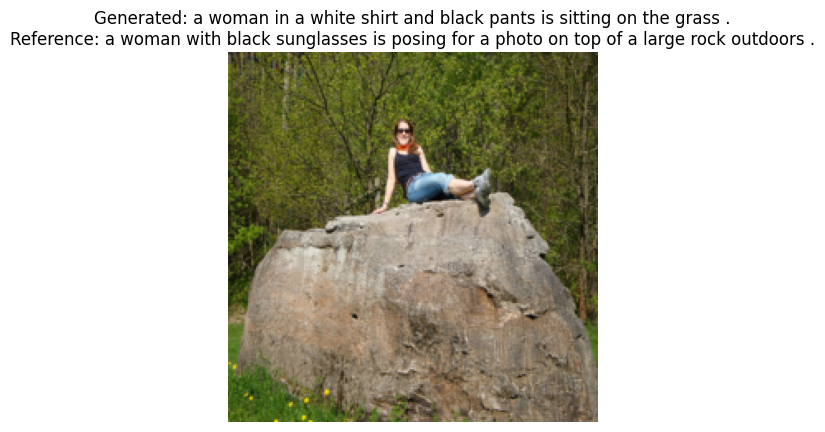

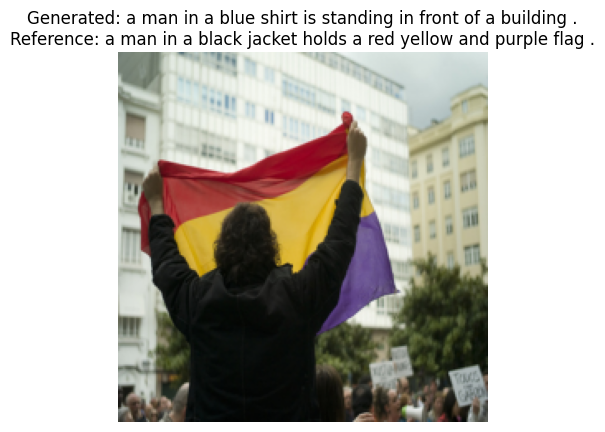

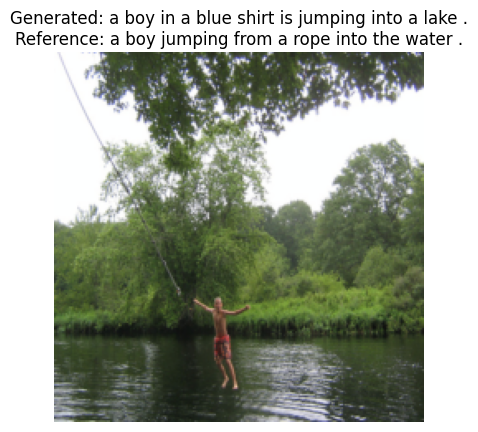

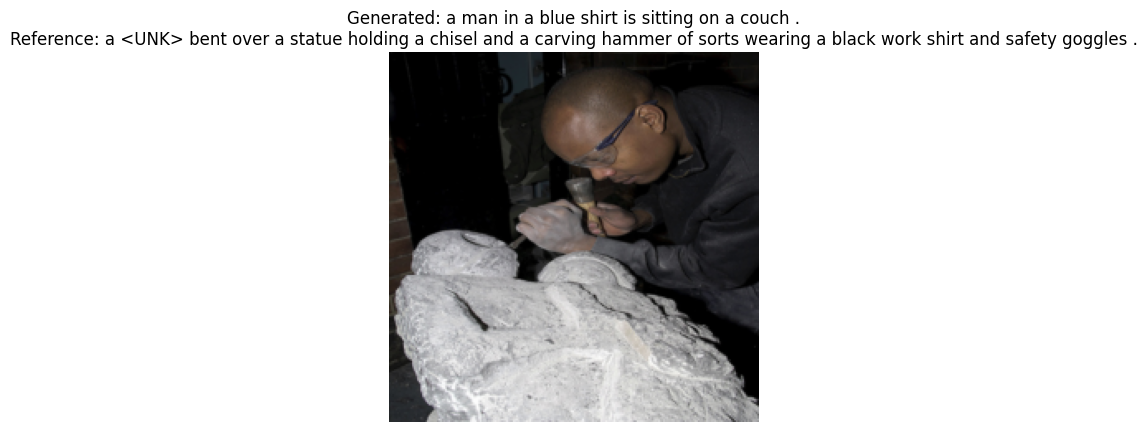

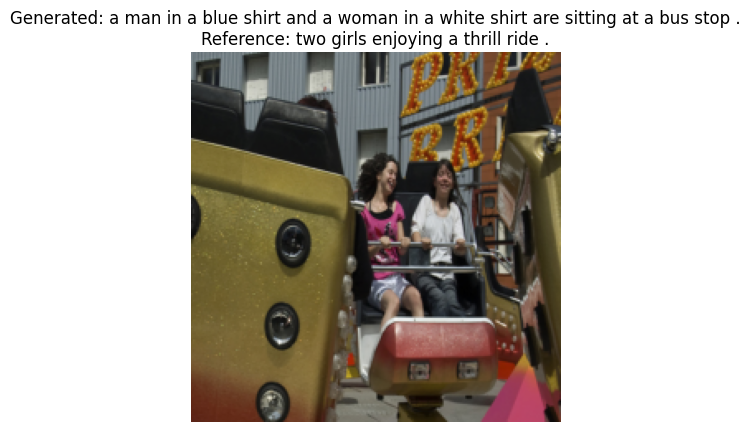

: 

In [ ]:
best_encoder.load_state_dict(torch.load("best_encoder.pth"))
best_decoder.load_state_dict(torch.load("best_decoder.pth"))

def test_examples(encoder, decoder, test_loader, vocab, num_examples=5):
    import matplotlib.pyplot as plt

    encoder.eval()
    decoder.eval()
    shown = 0

    with torch.no_grad():
        for imgs, caps in test_loader:
            imgs = imgs.to(device)
            features = encoder(imgs)
            output_ids = generate_caption(decoder, features[0].unsqueeze(0), vocab)
            # Convert indices to words
            candidate = [vocab.itos[idx] for idx in output_ids if idx not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]
            reference = [vocab.itos[idx.item()] for idx in caps[0] if idx.item() not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]

            # Display image and captions
            img_np = imgs[0].cpu().permute(1, 2, 0).numpy()
            # Undo normalization
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img_np = img_np.clip(0, 1)

            plt.imshow(img_np)
            plt.axis('off')
            plt.title(f"Generated: {' '.join(candidate)}\nReference: {' '.join(reference)}")
            plt.show()

            shown += 1
            if shown >= num_examples:
                break

# Example usage after training:
"""best_encoder, best_decoder, best_bleu = train()"""
print(f"Best BLEU score: {best_bleu:.4f}")
test_examples(best_encoder, best_decoder, test_loader, vocab, num_examples=5)